In [51]:
from share import *
import config

import cv2
import einops
import gradio as gr
import numpy as np
import torch
import random

from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.canny import CannyDetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler

from diffusers.utils import load_image
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [52]:
apply_canny = CannyDetector()

model = create_model('./models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict('./models/control_sd15_canny.pth', location='cuda'))
model = model.cuda()
ddim_sampler = DDIMSampler(model)

ControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_

In [53]:
def process(input_image, prompt, a_prompt, n_prompt, num_samples, image_resolution, ddim_steps, guess_mode, strength, scale, seed, eta, low_threshold, high_threshold):
    with torch.no_grad():
        img = resize_image(HWC3(input_image), image_resolution)
        H, W, C = img.shape

        detected_map = apply_canny(img, low_threshold, high_threshold)
        detected_map = HWC3(detected_map)

        control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
        un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                     shape, cond, verbose=False, eta=eta,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=un_cond)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

        results = [x_samples[i] for i in range(num_samples)]
    return [255 - detected_map] + results

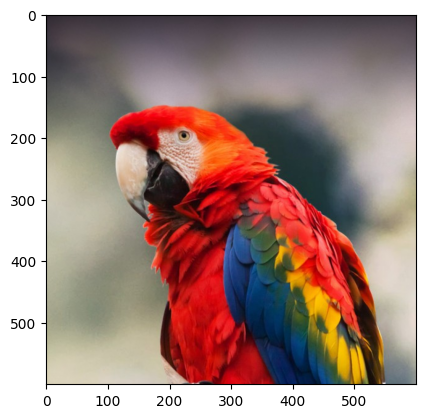

In [54]:
input_image = load_image(
    "https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg"
)
plt.imshow(input_image)
input_image = np.array(input_image)

Global seed set to 50


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.31it/s]


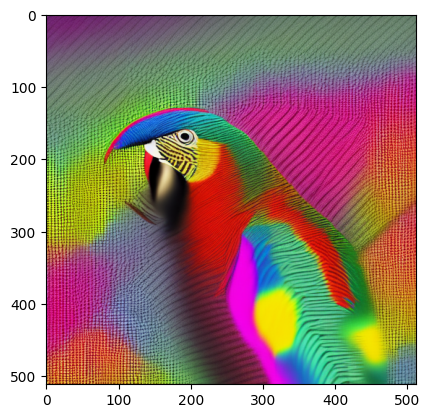

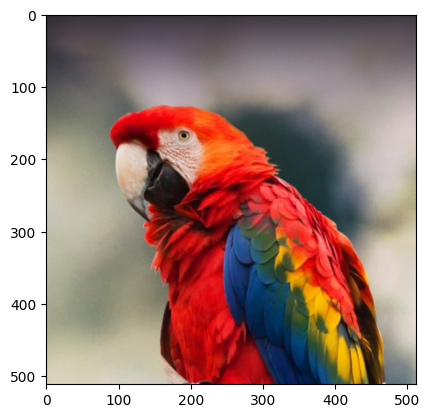

In [55]:
img = resize_image(HWC3(input_image), image_resolution)
H, W, C = img.shape
detected_map = apply_canny(img, low_threshold, high_threshold)
detected_map = HWC3(detected_map)

detected_map = img

image_resolution = 512
low_threshold = 100
high_threshold = 200
num_samples = 1
seed = 50
prompt = "a photo of a colorful parrot"
a_prompt = ""
n_prompt = "blurry"
guess_mode = False
strength = 1
ddim_steps = 20
eta = 0
scale = 9

with torch.no_grad():
    
    control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
    control = torch.stack([control for _ in range(num_samples)], dim=0)
    control = einops.rearrange(control, 'b h w c -> b c h w').clone()

    if seed == -1:
        seed = random.randint(0, 65535)
    seed_everything(seed)

    if config.save_memory:
        model.low_vram_shift(is_diffusing=False)

    cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
    un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
    shape = (4, H // 8, W // 8)

    if config.save_memory:
        model.low_vram_shift(is_diffusing=True)

    model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
    samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                 shape, cond, verbose=False, eta=eta,
                                                 unconditional_guidance_scale=scale,
                                                 unconditional_conditioning=un_cond)

    if config.save_memory:
        model.low_vram_shift(is_diffusing=False)

    x_samples = model.decode_first_stage(samples)
    x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

    results = [x_samples[i] for i in range(num_samples)]
plt.imshow(results[0])
plt.show()
plt.imshow(detected_map)
plt.show()

In [56]:
control.shape

torch.Size([1, 3, 512, 512])

In [57]:
un_cond['c_concat'][0].shape, un_cond['c_crossattn'][0].shape

(torch.Size([1, 3, 512, 512]), torch.Size([1, 77, 768]))

In [58]:
samples.shape

torch.Size([1, 4, 64, 64])

In [59]:
type(model)

cldm.cldm.ControlLDM

In [61]:
model.model.diffusion_model

ControlledUnetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=320, out_features=1280, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=1280, out_features=320, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0, inplace=False)
          (3): Conv2d(320, 320, kernel_size=

In [63]:
model.control_model

ControlNet(
  (time_embed): Sequential(
    (0): Linear(in_features=320, out_features=1280, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=1280, out_features=320, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0, inplace=False)
          (3): Conv2d(320, 320, kernel_size=(3, 3), s